In [1]:
import os
import numpy as np
import mne
from scipy.signal import butter, lfilter, stft
from skimage.transform import resize
from sklearn.utils import shuffle

# ----------------------- Filtering Utilities -----------------------

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=8, highcut=30, fs=250, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=-1)
    return y

# ----------------------- Preprocessing Core -----------------------

def common_average_reference(data):
    return data - np.mean(data, axis=0, keepdims=True)

def extract_channels(data, channel_names, selected_channels):
    cleaned = [ch.lower().replace('eeg:', '').replace('eeg-', '').strip() for ch in channel_names]
    selected = [ch.lower() for ch in selected_channels]

    idx = []
    for ch in selected:
        if ch in cleaned:
            idx.append(cleaned.index(ch))
        else:
            print(f"Warning: Channel '{ch}' not found!")

    if len(idx) == 0:
        raise ValueError("None of the selected channels were found!")
    
    return data[idx, :]

def sliding_window_segments(data, window_size, step):
    return np.array([
        data[:, start:start+window_size]
        for start in range(0, data.shape[1] - window_size + 1, step)
    ])

def stft_spectrogram(segment, fs=250, window_size=64, overlap=50):
    f, t, Zxx = stft(segment, fs=fs, window='hann', nperseg=window_size, noverlap=overlap)
    return f, t, np.abs(Zxx)

def extract_band_spectrogram(Sxx, f, band_low, band_high):
    idx = np.where((f >= band_low) & (f <= band_high))[0]
    return Sxx[idx, :]

def resize_spectrogram(spec, target_shape):
    return resize(spec, target_shape, mode='reflect', anti_aliasing=True)

# ----------------------- Main Preprocessing Function -----------------------

def preprocess_gdf_folder_stft(folder_path='data/GDF file/2b_train', 
                              selected_channels=['c3', 'cz', 'c4'],
                              fs=250,
                              car_lowcut=8,
                              car_highcut=30,
                              trial_window_sec=4,
                              sliding_window_sec=2,
                              sliding_step_sec=0.1,
                              stft_window=64,
                              stft_overlap=50):
    """
    Preprocess EEG .gdf files into CNN-ready spectrogram images.
    Output shape: X (N, 120, 32, 3), y (N,)
    Only uses trials with cue onset events for left (769) and right (770) hand.
    """
    X, y = [], []

    trial_window_samples = int(trial_window_sec * fs)
    sliding_window_samples = int(sliding_window_sec * fs)
    sliding_step_samples = int(sliding_step_sec * fs)

    event_code_to_label = {769: 0, 770: 1}  # Left, Right

    for filename in os.listdir(folder_path):
        if not filename.endswith('.gdf'):
            continue

        filepath = os.path.join(folder_path, filename)
        try:
            with mne.utils.use_log_level('ERROR'):
                raw = mne.io.read_raw_gdf(filepath, preload=True)
        except Exception as e:
            print(f"❌ Failed to load {filename}: {e}")
            continue

        print(f"\n📄 Processing {filename}")
        data = raw.get_data()
        channel_names = raw.info['ch_names']

        try:
            data_sel = extract_channels(data, channel_names, selected_channels)
        except ValueError as e:
            print(f"Skipping {filename}: {e}")
            continue

        data_car = common_average_reference(data_sel)
        data_filt = bandpass_filter(data_car, car_lowcut, car_highcut, fs)

        annotations = raw.annotations
        event_onsets = annotations.onset
        event_descriptions = annotations.description

        # Artifact trial timestamps
        artifact_times = [int((onset + 3) * fs) for onset, desc in zip(event_onsets, event_descriptions) if desc == '1023']

        for onset, desc in zip(event_onsets, event_descriptions):
            try:
                code = int(desc.strip())
            except:
                continue

            if code not in event_code_to_label:
                continue

            label = event_code_to_label[code]
            start_sample = int((onset + 3) * fs)
            end_sample = start_sample + trial_window_samples

            if any(abs(start_sample - a) < trial_window_samples for a in artifact_times):
                continue
            if end_sample > data_filt.shape[1]:
                continue

            trial = data_filt[:, start_sample:end_sample]
            segments = sliding_window_segments(trial, sliding_window_samples, sliding_step_samples)

            for segment in segments:
                channel_imgs = []

                for ch in range(len(selected_channels)):
                    sig = segment[ch, :]
                    f, t, Sxx = stft_spectrogram(sig, fs=fs, window_size=stft_window, overlap=stft_overlap)

                    mu_spec = extract_band_spectrogram(Sxx, f, 8, 14)
                    mu_resized = resize_spectrogram(mu_spec, (20, 32))

                    beta_spec = extract_band_spectrogram(Sxx, f, 16, 30)
                    beta_resized = resize_spectrogram(beta_spec, (20, 32))

                    combined_spec = np.vstack([mu_resized, beta_resized])  # (40, 32)
                    channel_imgs.append(combined_spec)

                img = np.vstack(channel_imgs)             # (120, 32)
                img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)  # (120, 32, 3)

                img = (img - np.mean(img)) / (np.std(img) + 1e-6)  # Normalize

                X.append(img)
                y.append(label)

    X = np.array(X)  # ✅ Fixed: use X and y, not undefined variables
    y = np.array(y)
    X, y = shuffle(X, y, random_state=42)

    print(f"\n✅ Done. Generated {len(X)} samples from {len(os.listdir(folder_path))} files.")
    print(f"🟢 X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# ----------------------- Example Usage -----------------------

# Uncomment this to test
if __name__ == "__main__":
    X, y = preprocess_gdf_folder_stft('data/GDF file/2b_train')
    np.save('X_preprocessed.npy', X)
    np.save('y_preprocessed.npy', y)



📄 Processing B0101T.gdf

📄 Processing B0102T.gdf

📄 Processing B0103T.gdf

📄 Processing B0201T.gdf

📄 Processing B0202T.gdf

📄 Processing B0203T.gdf

📄 Processing B0301T.gdf

📄 Processing B0302T.gdf

📄 Processing B0303T.gdf

📄 Processing B0401T.gdf

📄 Processing B0402T.gdf

📄 Processing B0403T.gdf

📄 Processing B0501T.gdf

📄 Processing B0502T.gdf

📄 Processing B0503T.gdf

📄 Processing B0601T.gdf

📄 Processing B0602T.gdf

📄 Processing B0603T.gdf

📄 Processing B0701T.gdf

📄 Processing B0702T.gdf

📄 Processing B0703T.gdf

📄 Processing B0801T.gdf

📄 Processing B0802T.gdf

📄 Processing B0803T.gdf

📄 Processing B0901T.gdf

📄 Processing B0902T.gdf

📄 Processing B0903T.gdf

✅ Done. Generated 63546 samples from 27 files.
🟢 X shape: (63546, 120, 32, 3), y shape: (63546,)


In [2]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time 
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sns


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedEEGCNNV3(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedEEGCNNV3, self).__init__()

        self.act = nn.SiLU()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.se_fc1 = nn.Linear(256, 64)
        self.se_fc2 = nn.Linear(64, 256)

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256 * 8 * 2, 256)  # Corrected here
        self.fc2 = nn.Linear(256, num_classes)

    def se_block(self, x):
        b, c, _, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.act(self.se_fc1(y))
        y = torch.sigmoid(self.se_fc2(y)).view(b, c, 1, 1)
        return x * y

    def forward(self, x):
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        x = self.se_block(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedEEGCNNV3().to(device)
dummy_input = torch.randn(2, 3, 120, 32).to(device)
output = model(dummy_input)
print(output.shape)  # Should be: torch.Size([2, 2])
from torchsummary import summary
summary(model, input_size=(3, 120, 32))  # Exclude batch size


torch.Size([2, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 60, 16]           2,432
       BatchNorm2d-2           [-1, 32, 60, 16]              64
              SiLU-3           [-1, 32, 60, 16]               0
            Conv2d-4            [-1, 64, 30, 8]          18,496
       BatchNorm2d-5            [-1, 64, 30, 8]             128
              SiLU-6            [-1, 64, 30, 8]               0
            Conv2d-7           [-1, 128, 15, 4]          73,856
       BatchNorm2d-8           [-1, 128, 15, 4]             256
              SiLU-9           [-1, 128, 15, 4]               0
           Conv2d-10            [-1, 256, 8, 2]         295,168
      BatchNorm2d-11            [-1, 256, 8, 2]             512
             SiLU-12            [-1, 256, 8, 2]               0
AdaptiveAvgPool2d-13            [-1, 256, 1, 1]               0
           Linear-14

In [5]:
def augment_spec(x, time_mask=10, freq_mask=5):
    """Apply random time and frequency masking to a spectrogram."""
    # x: Tensor of shape (C=3, H=120, W=32)
    c, h, w = x.shape
    x_aug = x.clone()

    # Time masking (along H)
    if torch.rand(1).item() < 0.5:
        t_indices = torch.randint(0, h, (time_mask,))
        x_aug[:, t_indices, :] = 0

    # Frequency masking (along W)
    if torch.rand(1).item() < 0.5:
        f_indices = torch.randint(0, w, (freq_mask,))
        x_aug[:, :, f_indices] = 0

    return x_aug

In [6]:
class EEGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx].astype(np.float32)
        img = (img - img.mean()) / (img.std() + 1e-6)
        img = torch.tensor(img).permute(2, 0, 1)  # (C, H, W)

        if self.augment:
            img = augment_spec(img)

        label = torch.tensor(self.y[idx]).long()
        return img, label

In [7]:
# ---- Load preprocessed data ----
X = np.load("X_preprocessed.npy")
y = np.load("y_preprocessed.npy")

In [8]:
class LazyEEGDataset(Dataset):
    def __init__(self, X_path, y_path, indices):
        self.X = np.load(X_path, mmap_mode='r')  # Lazy load (memory-mapped)
        self.y = np.load(y_path)[indices]
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        x = self.X[i].transpose(2, 0, 1)  # (C, H, W)
        y = self.y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

def create_dataloaders_with_test(X_path, y_path, batch_size=16):
    total_indices = np.arange(len(np.load(y_path)))
    y_full = np.load(y_path)

    # Split train+val vs test
    trainval_idx, test_idx = train_test_split(
        total_indices, test_size=0.15, stratify=y_full, random_state=42
    )

    # Split train vs val from trainval
    train_idx, val_idx = train_test_split(
        trainval_idx, test_size=0.176, stratify=y_full[trainval_idx], random_state=42
    )

    # Create datasets with indices
    train_dataset = LazyEEGDataset(X_path, y_path, train_idx)
    val_dataset   = LazyEEGDataset(X_path, y_path, val_idx)
    test_dataset  = LazyEEGDataset(X_path, y_path, test_idx)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader


In [9]:
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total
def train_model(model, train_loader, val_loader, device, epochs=300, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader, device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(total_loss)
        val_losses.append(criterion(model(next(iter(val_loader))[0].to(device)), next(iter(val_loader))[1].to(device)).item())

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Loss: {total_loss:.4f}")

    return train_accuracies, val_accuracies, train_losses, val_losses


In [10]:
def plot_training_curves(train_accuracies, val_accuracies, train_losses, val_losses):
    best_epoch = np.argmax(val_accuracies)
    best_val_acc = val_accuracies[best_epoch]

    plt.figure(figsize=(14, 5))

    # --- Accuracy curve ---
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Acc', marker='o')
    plt.plot(val_accuracies, label='Val Acc', marker='s')
    plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best Epoch ({best_epoch+1})')

    # Highlight best val acc with an 'x'
    plt.plot(best_epoch, best_val_acc, marker='x', markersize=10, color='red', label=f'Best Val Acc {best_val_acc:.4f}')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Loss curve ---
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='s')
    plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best Epoch ({best_epoch+1})')

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch 1/20 | Train Acc: 0.5603, Val Acc: 0.5700, Loss: 1897.7639
Epoch 2/20 | Train Acc: 0.5739, Val Acc: 0.5750, Loss: 1879.8070
Epoch 3/20 | Train Acc: 0.5781, Val Acc: 0.5850, Loss: 1870.6992
Epoch 4/20 | Train Acc: 0.5832, Val Acc: 0.5856, Loss: 1861.3537
Epoch 5/20 | Train Acc: 0.5903, Val Acc: 0.5944, Loss: 1850.1546
Epoch 6/20 | Train Acc: 0.5971, Val Acc: 0.5854, Loss: 1840.4726
Epoch 7/20 | Train Acc: 0.6051, Val Acc: 0.6045, Loss: 1828.1463
Epoch 8/20 | Train Acc: 0.6098, Val Acc: 0.6117, Loss: 1809.6238
Epoch 9/20 | Train Acc: 0.6230, Val Acc: 0.6193, Loss: 1782.5236
Epoch 10/20 | Train Acc: 0.6353, Val Acc: 0.6231, Loss: 1750.4928
Epoch 11/20 | Train Acc: 0.6459, Val Acc: 0.6405, Loss: 1718.9571
Epoch 12/20 | Train Acc: 0.6596, Val Acc: 0.6535, Loss: 1673.1387
Epoch 13/20 | Train Acc: 0.6788, Val Acc: 0.6644, Loss: 1616.5471
Epoch 14/20 | Train Acc: 0.6956, Val Acc: 0.6839, Loss: 1550.6940
Epoch 15/20 | Train Acc: 0.7160, Val Acc: 0.7001, Loss: 1471.0146
Epoch 16/20 | Train

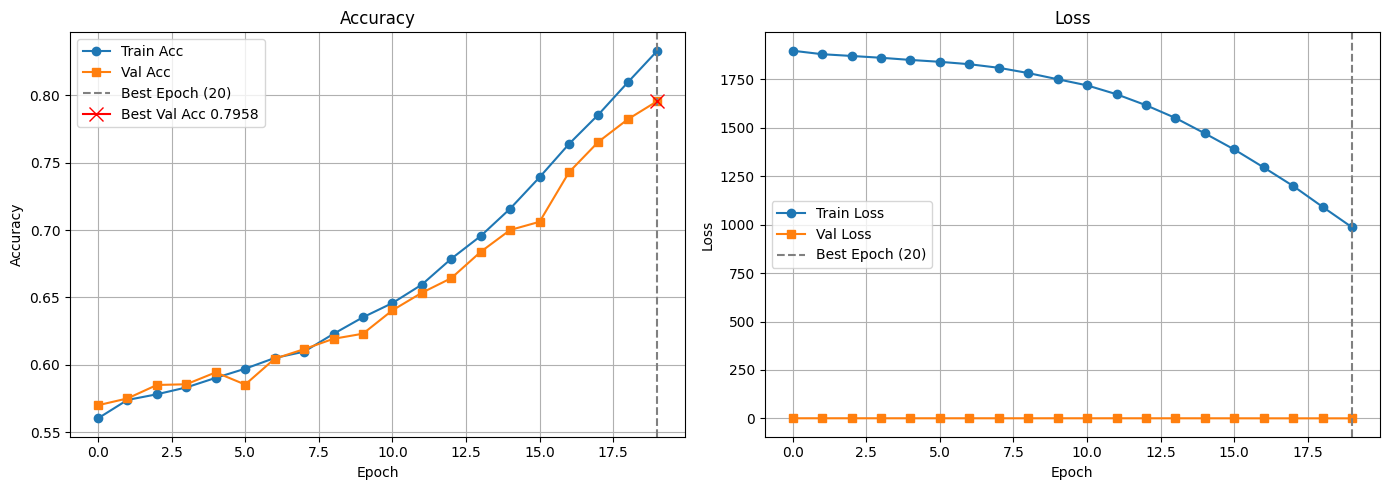

In [11]:
if __name__ == "__main__":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = EnhancedEEGCNNV3().to(device)

    train_loader, val_loader, test_loader = create_dataloaders_with_test(
        'X_preprocessed.npy',
        'y_preprocessed.npy',
        batch_size=16
    )

    train_accs, val_accs, train_losses, val_losses = train_model(
        model, train_loader, val_loader, device, epochs=20
    )

    plot_training_curves(train_accs, val_accs, train_losses, val_losses)


In [12]:
#how much left and rigth is considered
import torch
from collections import Counter

def analyze_left_right_distribution(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Count ground truth
    label_counts = Counter(all_labels)
    pred_counts = Counter(all_preds)

    # Display summary
    print("\n📊 Ground Truth Distribution:")
    print(f"Left (0): {label_counts.get(0,0)}")
    print(f"Right (1): {label_counts.get(1,0)}")

    print("\n📊 Predicted Distribution:")
    print(f"Left (0): {pred_counts.get(0,0)}")
    print(f"Right (1): {pred_counts.get(1,0)}")

    # Per-class accuracy
    left_correct = sum((p == l) and (l == 0) for p, l in zip(all_preds, all_labels))
    right_correct = sum((p == l) and (l == 1) for p, l in zip(all_preds, all_labels))

    left_total = label_counts.get(0,0)
    right_total = label_counts.get(1,0)

    left_acc = left_correct / left_total if left_total > 0 else 0
    right_acc = right_correct / right_total if right_total > 0 else 0

    print("\n✅ Per-Class Accuracy:")
    print(f"Left Accuracy: {left_acc*100:.2f}% ({left_correct}/{left_total})")
    print(f"Right Accuracy: {right_acc*100:.2f}% ({right_correct}/{right_total})")

    # Overall accuracy
    overall_acc = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)
    print(f"\n🎯 Overall Accuracy: {overall_acc*100:.2f}%")

# Example usage:
analyze_left_right_distribution(model, test_loader, device)


📊 Ground Truth Distribution:
Left (0): 4769
Right (1): 4763

📊 Predicted Distribution:
Left (0): 4520
Right (1): 5012

✅ Per-Class Accuracy:
Left Accuracy: 77.17% (3680/4769)
Right Accuracy: 82.36% (3923/4763)

🎯 Overall Accuracy: 79.76%


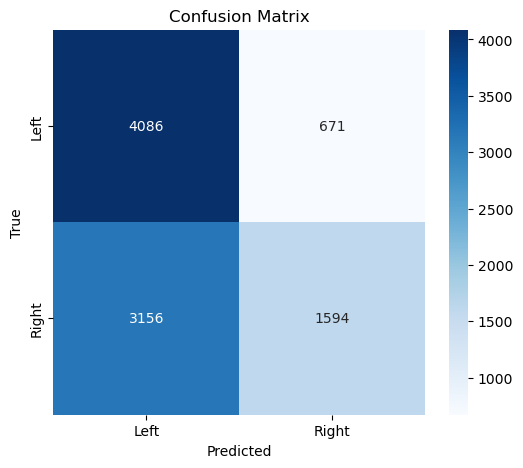

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Left", "Right"], yticklabels=["Left", "Right"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [15]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============================
# Your EEG Dataset
# ============================
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = torch.tensor(self.X[idx]).permute(2, 0, 1).float()
        label = torch.tensor(self.y[idx]).long()
        return img, label

# ============================
# Function: Compute metrics for 9 subjects
# ============================
def evaluate_per_subject(model, X, y, subject_ids, device='cpu', batch_size=32, save_cm=False):
    """
    Evaluate the model separately for each subject.
    Prints confusion matrix + accuracy/precision/recall/F1 for each.
    """
    dataset = EEGDataset(X, y)
    results = []

    print(f"{'Subject':<8} {'Accuracy (%)':<12} {'Precision (%)':<14} {'Recall (%)':<12} {'F1-score (%)':<12}")

    for subject_id in range(1, 10):
        indices = np.where(subject_ids == subject_id)[0]
        if len(indices) == 0:
            continue

        loader = DataLoader(Subset(dataset, indices), batch_size=batch_size, shuffle=False)

        all_preds, all_labels = [], []

        model.eval()
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = outputs.argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        results.append([accuracy, precision, recall, f1])

        print(f"Sub{subject_id:<4}  {accuracy*100:>8.2f}       {precision*100:>8.2f}         {recall*100:>8.2f}       {f1*100:>8.2f}")

        if save_cm:
            plt.figure(figsize=(4, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f"Confusion Matrix - Subject {subject_id}")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.savefig(f'confusion_matrix_subject_{subject_id}.png')
            plt.close()

    # Averages
    acc_avg = np.mean([r[0] for r in results])
    prec_avg = np.mean([r[1] for r in results])
    recall_avg = np.mean([r[2] for r in results])
    f1_avg = np.mean([r[3] for r in results])

    print(f"{'Average':<8} {acc_avg*100:>8.2f}       {prec_avg*100:>8.2f}         {recall_avg*100:>8.2f}       {f1_avg*100:>8.2f}")

    return results

# ============================
# Example usage
# ============================
if __name__ == "__main__":
    # Load your test set
    X_test = np.load('X_preprocessed.npy')
    y_test = np.load('y_preprocessed.npy')
    subject_ids_test = np.load('subject_ids_test.npy')

    # Load your model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Evaluate
    results = evaluate_per_subject(model, X_test, y_test, subject_ids_test, device=device, save_cm=True)


Subject  Accuracy (%) Precision (%)  Recall (%)   F1-score (%)
Sub1        84.47          83.19            87.60          85.34
Sub2        85.92          83.59            87.01          85.27
Sub3        86.78          84.97            89.65          87.25
Sub4        85.10          83.40            86.65          84.99
Sub5        86.09          84.11            88.04          86.03
Sub6        88.12          84.31            92.78          88.34
Sub7        85.26          83.00            90.62          86.64
Sub8        84.95          80.91            90.41          85.40
Sub9        86.30          85.94            89.28          87.58
Average     85.89          83.71            89.12          86.31


In [19]:
torch.save(model.state_dict(), 'EnhancedEEGCNNV3_final.pth')
import torch
from EnhancedEEGCNNV3_final.pth import EnhancedEEGCNNV3  # Use the file name where your model is defined

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EnhancedEEGCNNV3(num_classes=2)
model.load_state_dict(torch.load('EnhancedEEGCNNV3_final.pth', map_location=device))
model.to(device)
model.eval()


ModuleNotFoundError: No module named 'EnhancedEEGCNNV3_final'

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# === 1. Load your data ===
X_test = np.load('X_preprocessed.npy')
y_test = np.load('y_preprocessed.npy')
subject_ids_test = np.load('subject_ids_test.npy')  # You must have this!

# === 2. Load your model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedEEGCNNV3()  # Replace with your model class
model.load_state_dict(torch.load('EnhancedEEGCNNV3_final.pth'))  # Replace
model.to(device)
model.eval()

# === 3. EEG Dataset ===
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = torch.tensor(self.X[idx]).permute(2, 0, 1).float()
        label = torch.tensor(self.y[idx]).long()
        return img, label

full_test_dataset = EEGDataset(X_test, y_test)

# === 4. Per-subject evaluation ===
results = []

print(f"{'Subject':<8} {'Accuracy (%)':<12} {'Precision (%)':<14} {'Recall (%)':<12} {'F1-score (%)':<12}")

for subject_id in range(1, 10):  # Sub1 to Sub9
    indices = np.where(subject_ids_test == subject_id)[0]
    if len(indices) == 0:
        continue

    subject_dataset = Subset(full_test_dataset, indices)
    subject_loader = DataLoader(subject_dataset, batch_size=32, shuffle=False)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in subject_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Manual confusion matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    if cm.shape == (2, 2):
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        results.append([accuracy, precision, recall, f1])

        print(f"Sub{subject_id:<4}   {accuracy*100:>10.2f}   {precision*100:>10.2f}   {recall*100:>10.2f}   {f1*100:>10.2f}")

        print(f"Confusion Matrix (Sub{subject_id}):\n{cm}\n")

        # === Optional: Cross-check ===
        print(classification_report(all_labels, all_preds, target_names=['Left', 'Right']))

    else:
        print(f"⚠️ Skipped Sub{subject_id}: not enough class variety.")

# === 5. Averages ===
acc_avg = np.mean([r[0] for r in results])
prec_avg = np.mean([r[1] for r in results])
recall_avg = np.mean([r[2] for r in results])
f1_avg = np.mean([r[3] for r in results])

print(f"{'Average':<8} {acc_avg*100:>10.2f}   {prec_avg*100:>10.2f}   {recall_avg*100:>10.2f}   {f1_avg*100:>10.2f}")


Subject  Accuracy (%) Precision (%)  Recall (%)   F1-score (%)
Sub1           51.60        51.60       100.00        68.07
Confusion Matrix (Sub1):
[[  0 726]
 [  0 774]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       726
       Right       0.52      1.00      0.68       774

    accuracy                           0.52      1500
   macro avg       0.26      0.50      0.34      1500
weighted avg       0.27      0.52      0.35      1500

Sub2           46.83        46.83       100.00        63.79
Confusion Matrix (Sub2):
[[  0 638]
 [  0 562]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       638
       Right       0.47      1.00      0.64       562

    accuracy                           0.47      1200
   macro avg       0.23      0.50      0.32      1200
weighted avg       0.22      0.47      0.30      1200



d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d

Sub3           50.44        50.44       100.00        67.06
Confusion Matrix (Sub3):
[[  0 446]
 [  0 454]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       446
       Right       0.50      1.00      0.67       454

    accuracy                           0.50       900
   macro avg       0.25      0.50      0.34       900
weighted avg       0.25      0.50      0.34       900

Sub4           48.70        48.70       100.00        65.50
Confusion Matrix (Sub4):
[[  0 513]
 [  0 487]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       513
       Right       0.49      1.00      0.66       487

    accuracy                           0.49      1000
   macro avg       0.24      0.50      0.33      1000
weighted avg       0.24      0.49      0.32      1000



d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d

Sub5           48.64        48.64       100.00        65.44
Confusion Matrix (Sub5):
[[  0 565]
 [  0 535]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       565
       Right       0.49      1.00      0.65       535

    accuracy                           0.49      1100
   macro avg       0.24      0.50      0.33      1100
weighted avg       0.24      0.49      0.32      1100

Sub6           48.50        48.50       100.00        65.32
Confusion Matrix (Sub6):
[[  0 412]
 [  0 388]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       412
       Right       0.48      1.00      0.65       388

    accuracy                           0.48       800
   macro avg       0.24      0.50      0.33       800
weighted avg       0.24      0.48      0.32       800



d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d

Sub7           52.74        52.74       100.00        69.06
Confusion Matrix (Sub7):
[[  0 449]
 [  0 501]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       449
       Right       0.53      1.00      0.69       501

    accuracy                           0.53       950
   macro avg       0.26      0.50      0.35       950
weighted avg       0.28      0.53      0.36       950

Sub8           48.67        48.67       100.00        65.47
Confusion Matrix (Sub8):
[[  0 539]
 [  0 511]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       539
       Right       0.49      1.00      0.65       511

    accuracy                           0.49      1050
   macro avg       0.24      0.50      0.33      1050
weighted avg       0.24      0.49      0.32      1050



d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d

Sub9           54.10        54.10       100.00        70.21
Confusion Matrix (Sub9):
[[  0 459]
 [  0 541]]

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       459
       Right       0.54      1.00      0.70       541

    accuracy                           0.54      1000
   macro avg       0.27      0.50      0.35      1000
weighted avg       0.29      0.54      0.38      1000

Average       50.02        50.02       100.00        66.66


d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming module\python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [23]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, zero_division=0)


NameError: name 'y_true' is not defined